# 13 kNN Exploration

We are now ready to plot the average distances between neighboring oil glands.

The average distance between each oil gland and its 100 nearest neighbors has been compiled in `merged/avg_knn_distances.csv` for all 161 citrus fruits.

- Plot the average distance between each oil gland and its nearest neighbor, its 2nd nearest neighbor, 3rd nearest neighbor,..., and so on until its 25th neighbor.
- We pick only 25 neighbors to keep distances very local, so they won't be affected by the curvature of the ellipsoid.
- Thus it is safe to use the Euclidean distance

<img src="https://www.egr.msu.edu/~amezqui3/citrus/figs/knn01_panel.svg" width=700>

In [2]:
import glob
import os
import textwrap
import string

from sklearn import neighbors as nn
from sklearn import decomposition as decomp
from sklearn import preprocessing as prep
from sklearn.metrics import r2_score

import numpy as np
import numpy.polynomial.polynomial as P

import pandas as pd

import warnings
warnings.filterwarnings( "ignore")
import matplotlib.pyplot as plt
%matplotlib inline

### Load the compiled data measurements

In [4]:
df = pd.read_csv('../data/allometry/volumes_and_sphericities.csv')
df.head()

,citrus_id,label,kind,whole,exocarp,endocarp,rind,spine,mesocarp,oil_glands,...,sneed,janke,equancy,rho,area,volume,density_whole,density_exocarp,density_area,density_volume
0,C01_CRC2317_18B-18-9,L00,Lemons and Lemon Hybrids,160.687610,34.104516,88.077546,47.450018,6.902806,40.547212,0.228940,...,0.951930,0.950575,0.912011,0.991301,131.552197,141.634935,51.136488,240.935831,62.461899,58.015348
1,C01_CRC2317_18B-18-9,L01,Lemons and Lemon Hybrids,86.992947,16.597155,50.561608,26.259460,3.501201,22.758259,0.180907,...,0.983618,0.983413,0.965487,0.998762,85.078009,73.772020,66.304226,347.529450,67.796603,78.186825
2,C01_CRC2317_18B-18-9,L02,Lemons and Lemon Hybrids,82.898044,16.715139,51.140166,20.911448,1.698778,19.212670,0.172182,...,0.951965,0.950623,0.912486,0.991368,86.859773,75.990242,72.438380,359.255168,69.134419,79.023304
3,C01_CRC2317_18B-18-9,L03,Lemons and Lemon Hybrids,62.717743,14.892982,37.671975,14.998806,1.627702,13.371095,0.175542,...,0.962920,0.962225,0.940127,0.995483,70.871279,56.052537,92.748873,390.586653,82.078383,103.777639
4,C02_CRC3919_18A-24-1,L00,Lemons and Lemon Hybrids,103.970975,23.082609,61.024476,26.689248,1.951175,24.738073,0.573769,...,0.952981,0.949677,0.878024,0.981572,100.580813,94.474523,126.814238,571.209261,131.088620,139.561435


### Get the citrus groups of interest

In [5]:
citrus_names = ['Lemons and Lemon Hybrids', 'Mandarins and Mandarin Hybrids', 'Pummelos and Pummelo Hybrids', 
                'Sour Oranges and their hybrids', 'Sweet Oranges', 'Papedas', 'Trifoliates and Trifoliate Hybrids',
                'Microcitrus', 'Kumquats']
citrus_names = sorted(citrus_names)
citrus_names.append('Other')
citrus_ss = [[] for i in range(len(citrus_names))]
citrus_dict = dict(zip(citrus_names, citrus_ss))

for i in range(len(df)):
    kind = df.iloc[i,2]
    citrus_dict[kind].append(i)
keys = list(citrus_dict.keys())

### Load the kNN average distances for each citrus

In [6]:
dst = '../data/allometry/'
knn = pd.read_csv(dst + 'avg_knn_distances.csv').iloc[:,3:].values

### Observe the kNN distance distribution for a particular citrus group.

- With `keys[8]` we refer to Trifoliates
- We observe that the distance to neighbor grows following a square root model.
- We thus fit a linear model between the squared distance and the neighbor index.

In [9]:
knn_max = 25
i = 8
key = keys[i]
xx = np.arange(knn_max)+1
yy = np.mean(knn[citrus_dict[key],:knn_max], axis = 0)**2

new_series = P.Polynomial.fit(xx,yy, deg=1, full=False)
foo = new_series.convert().coef
r2 = r2_score(yy, new_series(xx))
print(key, foo, '\t', r2)

Trifoliates and Trifoliate Hybrids [0.05925324 0.5464681 ] 	 0.9999876901962277


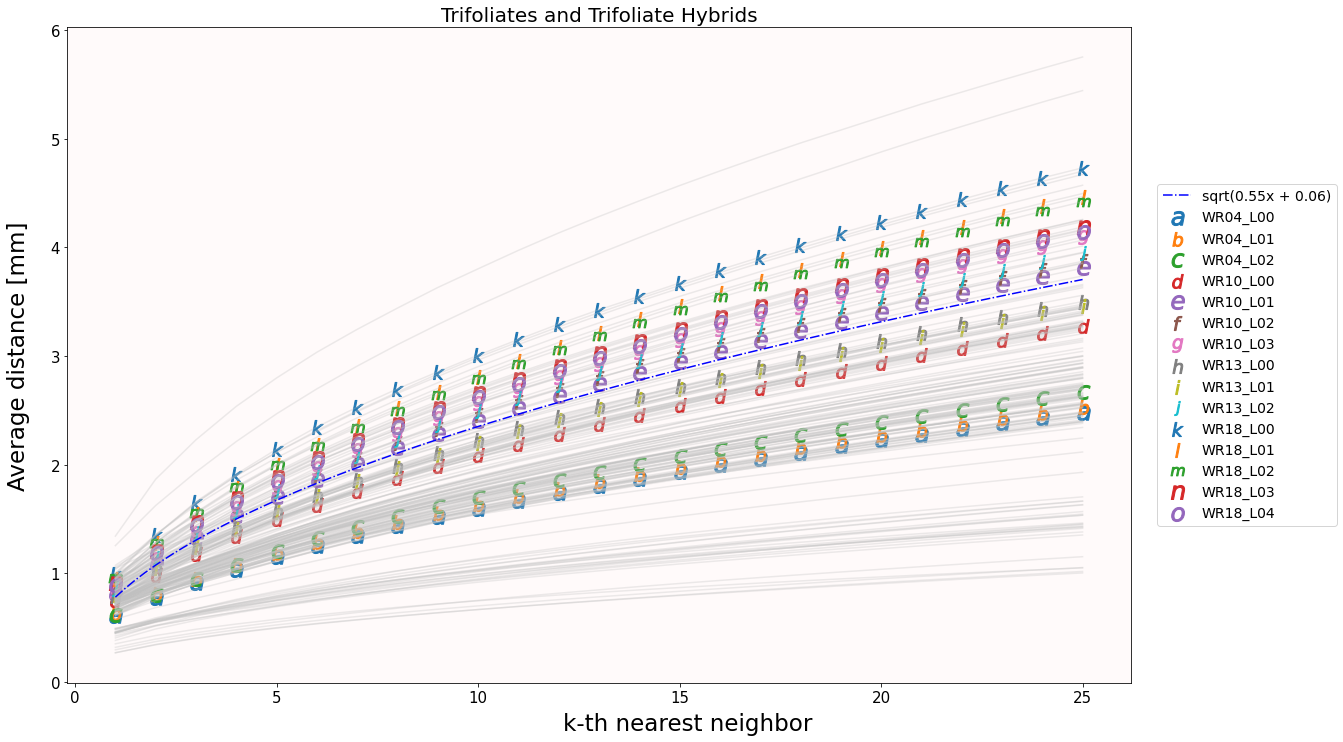

In [11]:
fs = 20
fig, ax = plt.subplots(1,1,figsize=(18,10), sharex=True, sharey=True)

ax.set_facecolor('snow')
ax.tick_params(labelsize=15)
for j in range(len(knn)):
    ax.plot(xx, knn[j, :knn_max],
               color='silver', alpha=0.3)
for i,j in enumerate(citrus_dict[key]):
    mark = '$' + string.ascii_letters[i] + '$'
    bcode = int(df.citrus_id[j].split('_')[0][-2:])
    if bcode not in [9]:
        ax.scatter(xx, knn[j, :knn_max],
                   s=200, marker=mark,
                   label=df.iloc[j,0].split('_')[0] + '_' + df.iloc[j,1])
#bar = ax.axline(xy1=(0,foo[0]), slope=foo[1], color='b', label='r', ls='-.')
labm = 'sqrt({:.2f}x + {:.2f})'.format(foo[1],foo[0])
ax.plot(np.linspace(1,knn_max,100), np.sqrt(new_series(np.linspace(1,knn_max,100))),
        color='b', label=labm, ls='-.')
ax.set_title(key, fontsize=fs)
#ax.set_xlabel(, fontsize=fs);
#ax.set_ylabel(, fontsize=fs);
ax.legend(loc='right', bbox_to_anchor=(1.2,0.5), fontsize=14)
fig.text(0.5, -0.02, 'k-th nearest neighbor', ha='center', fontsize=23)
fig.text(-0.025, 0.5, 'Average distance [mm]', va='center', rotation='vertical', fontsize=23)

#fig.suptitle('Avg distance to {:02d}-nearest neighbors'.format(knn_max), fontsize=28);
fig.tight_layout();

## Plot the kNN distribution for all the groups

- For each group, we fit a square root model

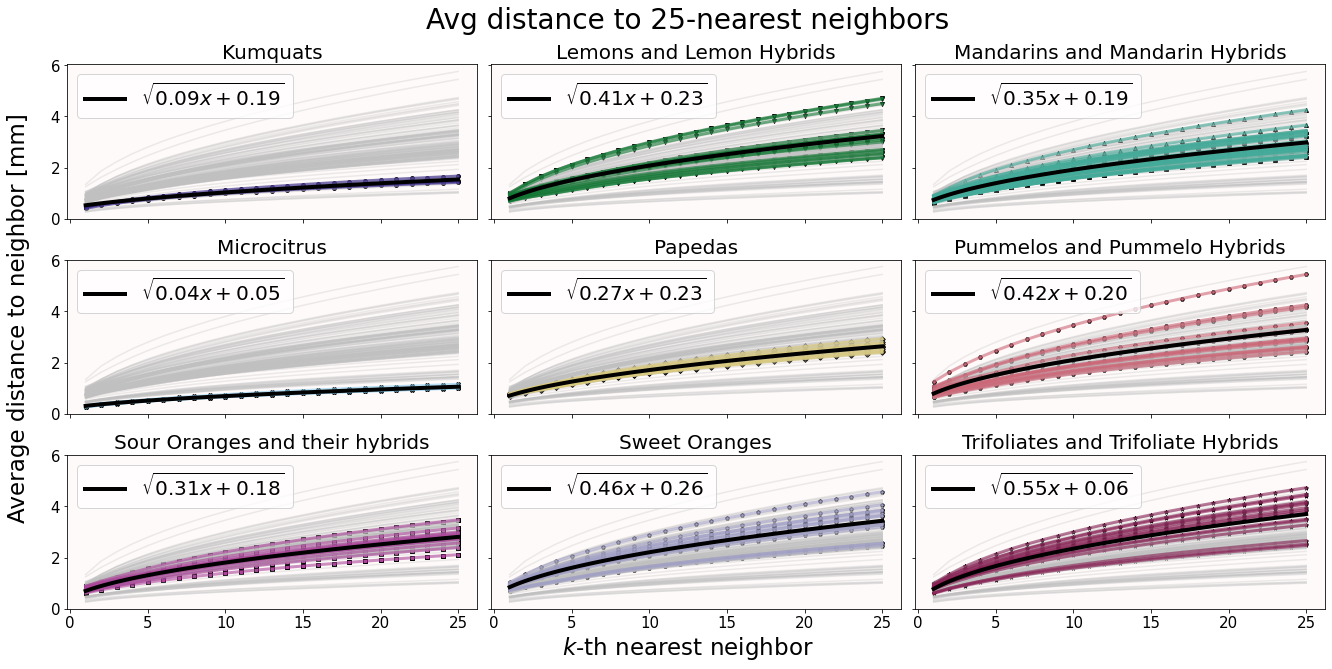

In [14]:
marker = ['o', 'v', '^', 'X', 'D', 
          'H', 's', 'p', '*', 'P']
col_tol = ['#332288', '#117733', '#44aa99', '#88ccee', '#ddcc77', 
           '#cc6677', '#aa4499', '#a09fc5', '#882255', '#111111']
fs = 20

knn_max = 25
knn2 = knn
fig, ax = plt.subplots(3,3,figsize=(18,9), sharex=True, sharey=True)
ax = ax.ravel()
xx = np.arange(knn_max)+1

for i in range(len(ax)):
    key = keys[i]
    yy = np.mean(knn[citrus_dict[key],:knn_max], axis = 0)**2
    new_series = P.Polynomial.fit(xx,yy, deg=1, full=False)
    foo = new_series.convert().coef
    
    labm = '$\\sqrt{{{:.2f}x + {:.2f}}}$'.format(foo[1],foo[0])
    
    ax[i].set_facecolor('snow')
    ax[i].tick_params(labelsize=15)
    for j in range(len(knn)):
        if j not in citrus_dict[key]:
            ax[i].plot(xx, knn2[j, :knn_max],color='silver', alpha=0.3)
            
    for j in citrus_dict[key]:
        ax[i].plot(xx, knn2[j, :knn_max],
                   color=col_tol[i], lw=3, alpha=0.6)
    for j in citrus_dict[key]:
        ax[i].scatter(xx, knn2[j, :knn_max], 
                      s=15, alpha=1,
                      marker=marker[i], color=col_tol[i], 
                      edgecolor='k', linewidth=1);
    ax[i].set_title(key, fontsize=fs)
    ax[i].plot(np.linspace(1,knn_max,100), np.sqrt(new_series(np.linspace(1,knn_max,100))),
                color='k', label=labm, ls='-', lw=4)
    ax[i].legend(fontsize=20)
#ax.set_xlabel(, fontsize=fs);
#ax.set_ylabel(, fontsize=fs);
fig.text(0.5, -0.02, '$k$-th nearest neighbor', ha='center', fontsize=23)
fig.text(-0.025, 0.5, 'Average distance to neighbor [mm]', va='center', rotation='vertical', fontsize=23)

fig.suptitle('Avg distance to {:02d}-nearest neighbors'.format(knn_max), fontsize=28);
fig.tight_layout();

pname = dst + 'panel_knn{:02d}_growth'.format(knn_max)
#plt.savefig(pname+'.jpg', dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(pname+'.pdf', format='pdf', bbox_inches='tight')

fig.set_alpha(0)
plt.savefig(pname + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

### Perform PCA of the average distance to the 25 nearest neighbors

In [16]:
knn_max = 25
vals = knn[:, :knn_max].copy()
scaler = prep.StandardScaler(with_mean=True, with_std=True)
scaler.fit(vals)
vals = scaler.transform(vals)

pca_params = {'n_components': None, 'whiten': False}
pca = decomp.PCA(**pca_params)
pca.fit(vals)
vals = pca.transform(vals)

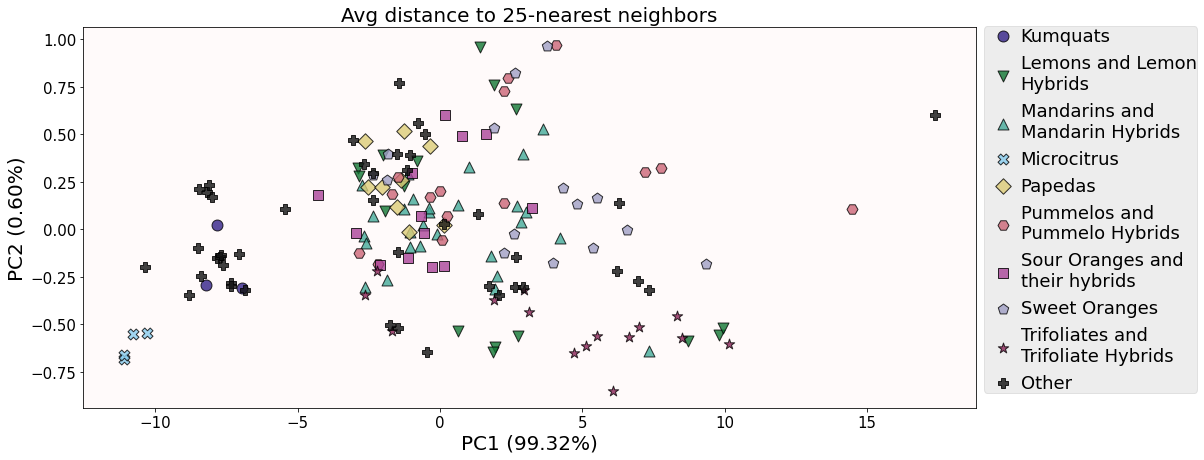

In [18]:
fig, ax = plt.subplots(1,1,figsize=(16,7))

for i,key in enumerate(citrus_dict):
    ax.scatter(vals[citrus_dict[key], 0], vals[citrus_dict[key], 1], s=120, alpha=0.8,
               marker=marker[i], color=col_tol[i], label=key,
               edgecolor='k', linewidth=1);
ax.set_xlabel('PC1 ({:.2f}%)'.format(pca.explained_variance_ratio_[0]*100), fontsize=fs);
ax.set_ylabel('PC2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1]*100), fontsize=fs);

ax.set_facecolor('snow')
ax.tick_params(labelsize=15)
h, l = ax.get_legend_handles_labels()
l = ([textwrap.fill(t, 18)  for t in l])

fig.legend(h,l,fontsize=18, ncol=1,framealpha=0.4, facecolor='lightgray', loc='upper right',
           bbox_to_anchor=(1.1, 0.9), borderpad=0.05,
           edgecolor='silver', handletextpad=0.);
ax.set_title('Avg distance to {:02d}-nearest neighbors'.format(knn_max), fontsize=fs);

pname = dst + 'pca_knn{:02d}'.format(knn_max)
#plt.savefig(pname+'.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(pname+'.pdf', format='pdf', bbox_inches='tight')
fig.set_alpha(0)
plt.savefig(pname + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

## Allometry regarding the average distance to nearest neighbor

- We observe that this distance is highly correlated with fruit size and oil gland density

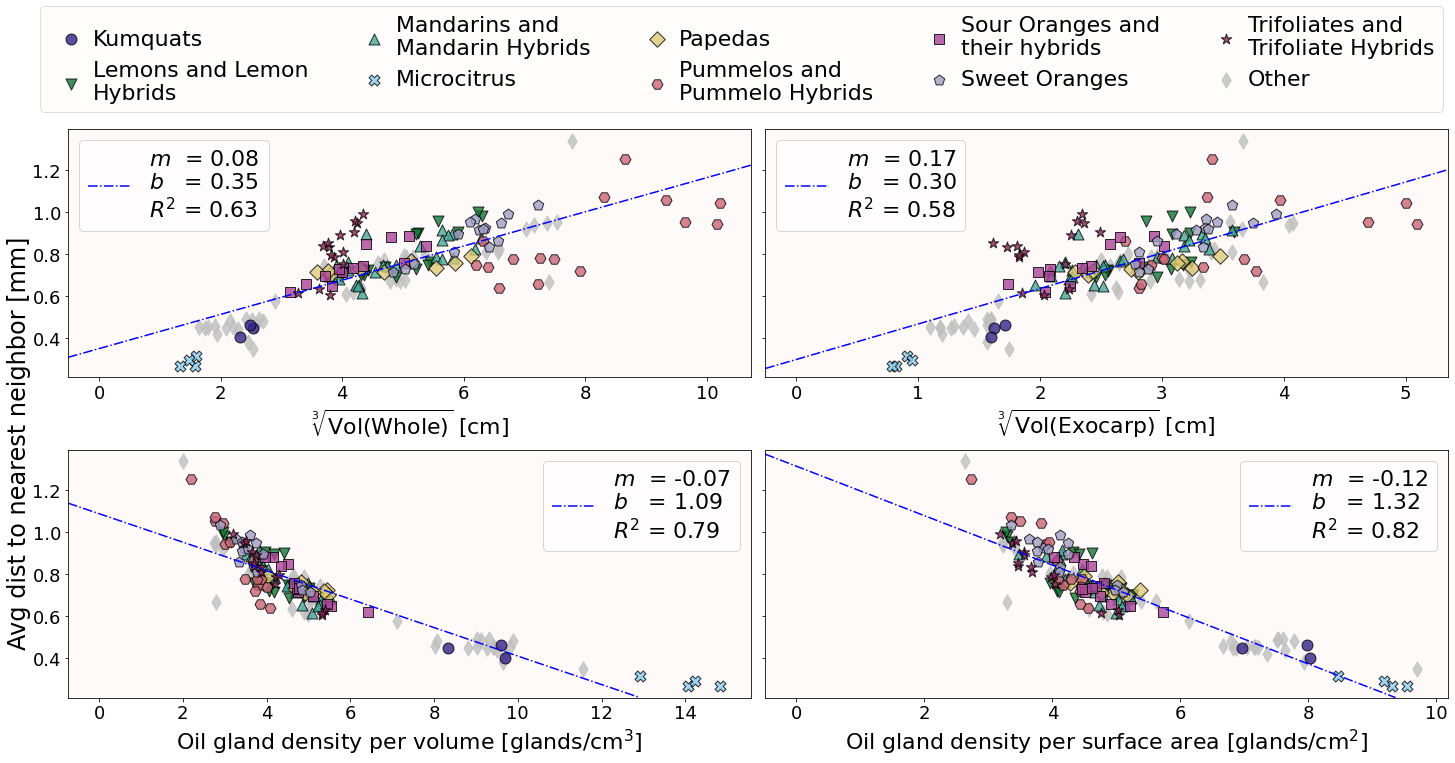

In [19]:
fs = 22
marker = ['o', 'v', '^', 'X', 'D', 
          'H', 's', 'p', '*', 'P']
col_tol = ['#332288', '#117733', '#44aa99', '#88ccee', '#ddcc77', 
           '#cc6677', '#aa4499', '#a09fc5', '#882255', '#111111']

keys = list(citrus_dict.keys())
fig, ax = plt.subplots(2,2,figsize=(20,9), sharey=True)
ax = ax.ravel()
trait = ['whole', 'exocarp', 'oil_glands', 'density_area']
trait = ['density_whole', 'density_exo', 'density_vol', 'density_area']
trait = ['whole', 'exocarp', 'density_whole', 'density_exo', 'density_vol', 'density_area']
trait = ['whole', 'exocarp', 'density_whole', 'density_area']

for i in range(len(ax)):
    xx = np.cbrt(df[trait[i]])
    yy = knn[:,0]
    new_series = P.Polynomial.fit(xx,yy, deg=1, full=False)
    foo = new_series.convert().coef
    r2 = r2_score(yy, new_series(xx))
    label = '$m$  = {:.2f}\n$b$   = {:.2f}\n$R^2$ = {:.2f}'.format(foo[1], foo[0], r2)
    ax[i].axline(xy1=(0,foo[0]), slope=foo[1], color='b', ls='-.', label=label)
    if i == 2:
        ax[i].legend(loc = 'upper right', fontsize=fs)
        ax[i].set_xlabel('Oil gland density per volume [glands/cm$^3$]', fontsize=fs)
    elif i == 3:
        ax[i].legend(loc = 'upper right', fontsize=fs)
        ax[i].set_xlabel('Oil gland density per surface area [glands/cm$^2$]', fontsize=fs)
    else:
        ax[i].legend(loc = 'upper left', fontsize=fs)
        tt = '\;'.join(trait[i].title().split('_'))
        ax[i].set_xlabel('$\sqrt[3]{{\\rm Vol({})}}$ [cm]'.format(tt), fontsize=fs);

    key = keys[-1]
    ax[i].scatter(xx[citrus_dict[key]], yy[citrus_dict[key]], s=120, alpha=0.8,
               marker='d', color='silver', label='Other');
    for j in range(len(keys)-1):
        key = keys[j]
        ax[i].scatter(xx[citrus_dict[key]], yy[citrus_dict[key]], s=120, alpha=0.8,
                   marker=marker[j], color=col_tol[j], label=key,
                   edgecolor='k', linewidth=1);
    ax[i].set_facecolor('snow')
    ax[i].tick_params(labelsize=18)
    h, l = ax[i].get_legend_handles_labels()

ordering = list(range(2,len(keys)+1)) + [1]
hh = [h[k] for k in ordering]
ll = [textwrap.fill(l[k],18) for k in ordering]

fig.legend(hh,ll,fontsize=22, ncol=5,framealpha=0.5, facecolor='snow', loc='upper center',
           bbox_to_anchor=(0.5, 1.19),
           edgecolor='silver', handletextpad=0.);

fig.text(-0.01, 0.5, 'Avg dist to nearest neighbor [mm]', va='center', rotation='vertical', fontsize=fs+2)
#ax[0].set_ylabel('Avg dist to nearest neighbor [mm]', fontsize=fs);

fig.tight_layout();

pname = dst + 'knn01_panel'
#plt.savefig(pname+'.jpg', dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(pname+'.pdf', format='pdf', bbox_inches='tight')
fig.set_alpha(0)
plt.savefig(pname + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

### PCs are highly correlated, which explains why PC1 explains 99% of variance!

- Not surprising given that a root model fits nicely wrt knn index

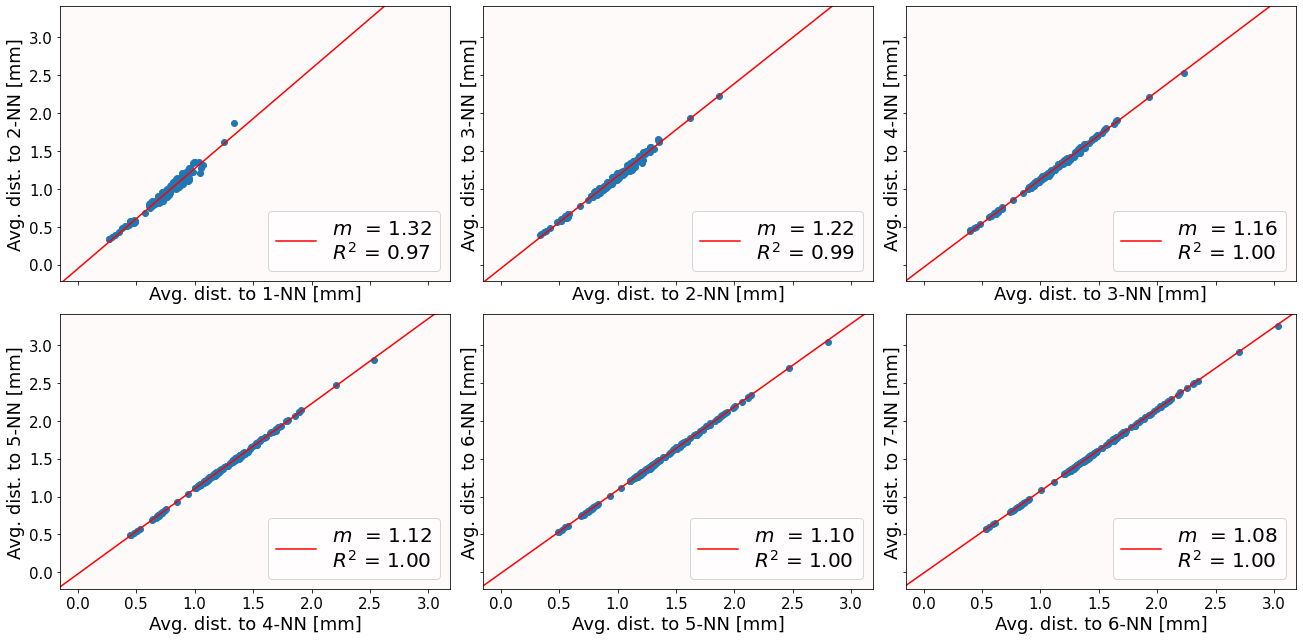

In [21]:
fig, ax = plt.subplots(2,3,figsize=(18,9), sharex=True, sharey=True)
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].set_facecolor('snow')
    ax[i].tick_params(labelsize=15)
    ax[i].scatter(knn[:,i], knn[:,i+1])
    ax[i].set_xlabel('Avg. dist. to {}-NN [mm]'.format(i+1), fontsize=18)
    ax[i].set_ylabel('Avg. dist. to {}-NN [mm]'.format(i+2), fontsize=18)
    new_series = P.Polynomial.fit(knn[:,i],knn[:,i+1], deg=1, full=False)
    r2 = r2_score(knn[:,i+1], new_series(knn[:,i]))
    foo = new_series.convert().coef
    ax[i].axline(xy1=(0,foo[0]), slope=foo[1], color='r', 
                 label='$m$  = {:.2f}\n$R^2$ = {:.2f}'.format(foo[1], r2))
    ax[i].legend(loc='lower right', fontsize=20)
    
fig.tight_layout();
pname = dst + 'knn_clust/knn_linear_relationship'

In [195]:
knn_max = 100
vals = attr[0].iloc[:, :knn_max].values.copy()
fname = dst + columns[0] + '_' + filename
pd.DataFrame(vals)#.to_csv(fname, index=False)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,760.049022,999.404515,1206.352074,1388.541355,1550.765494,1700.637837,1834.288594,1959.449661,2076.582471,2186.240933,...,6543.728872,6579.201440,6614.043181,6649.183047,6684.039581,6718.503625,6752.865955,6787.357650,6821.132892,6855.321096
1,722.319394,960.463040,1157.620101,1331.401387,1484.911700,1625.124626,1754.028519,1875.710521,1987.537779,2096.949035,...,6375.695495,6410.458415,6446.400879,6480.586765,6515.321032,6549.295744,6582.935507,6617.641676,6651.655028,6685.811994
2,717.332006,949.113911,1152.243455,1326.430093,1482.890240,1624.524668,1752.852237,1874.141301,1985.029295,2093.322466,...,6259.271714,6293.861195,6327.983710,6362.571169,6395.544241,6429.055672,6462.127277,6495.044951,6527.235601,6560.641913
3,689.027779,905.702735,1087.011022,1247.631416,1389.411770,1515.731524,1635.095960,1748.262703,1851.610362,1949.838750,...,5856.666382,5888.794273,5921.006956,5952.506196,5984.250615,6015.412455,6046.582851,6077.357682,6107.638979,6138.570104
4,735.751987,875.632858,984.808386,1089.530403,1192.311741,1294.571235,1389.116954,1477.967523,1561.857626,1639.483019,...,4735.404096,4761.252466,4786.509349,4811.823847,4836.758344,4861.945115,4886.740267,4911.505539,4936.269542,4960.704357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,907.351353,1205.352475,1466.587333,1688.728595,1882.193832,2060.810419,2222.561077,2375.307465,2521.762167,2658.182228,...,7959.352834,8002.576020,8048.347066,8091.854987,8134.168708,8176.806458,8219.301133,8260.753653,8302.821889,8342.654703
157,891.758555,1180.970663,1438.623029,1656.882946,1849.734120,2022.974850,2190.574029,2341.965850,2481.735757,2617.382342,...,7888.184307,7931.317625,7973.547819,8016.692343,8060.397862,8102.407436,8144.768016,8187.164155,8228.297406,8269.911785
158,948.405147,1243.062698,1495.896813,1716.775149,1913.411807,2091.151058,2256.071191,2408.889869,2552.436491,2688.245078,...,8102.356978,8146.529682,8191.324402,8235.334226,8278.623083,8322.379944,8365.845212,8409.726136,8453.419034,8495.227199
159,937.269793,1234.935712,1480.909376,1696.618049,1887.007625,2061.429105,2223.619502,2373.315108,2511.858549,2644.626959,...,7888.184081,7931.305549,7974.480829,8017.428982,8060.532942,8102.889493,8144.567549,8187.178944,8227.966287,8270.320327


In [178]:
knn_max = 100
vals = attr[0].iloc[:, :knn_max].values.copy()
scaler = prep.StandardScaler(with_mean=True, with_std=True)
scaler.fit(vals)
vals = scaler.transform(vals)

In [194]:
scaler.var_

array([  31764.95034063,   57103.17435201,   85850.05459416,
        116367.10483459,  147159.19139923,  177949.38247398,
        208713.78479605,  239525.9721506 ,  270568.14227728,
        301769.18526934,  333255.74957982,  364791.60785998,
        396193.94346646,  427910.79702758,  459754.74381207,
        491539.7516312 ,  523304.19323433,  555104.56470025,
        586783.97976326,  618887.61438411,  650845.3316543 ,
        682631.35010356,  714665.9524823 ,  746520.30299623,
        778338.47853831,  810343.38808102,  842380.87455866,
        874450.88861077,  906422.82907731,  938704.52188949,
        970650.8269615 , 1002728.50159514, 1034750.96228338,
       1066735.74434009, 1098859.98006866, 1131007.95817427,
       1162851.03570699, 1194753.29423958, 1226847.1399285 ,
       1259099.79662659, 1291420.59343935, 1323706.63060667,
       1355868.64358294, 1388103.84018332, 1420093.71135477,
       1452187.86343555, 1484138.11909985, 1516580.7238546 ,
       1548837.91200269,

In [9]:
src = '../preproc/merged/'
filename = src + 'uniform_distribution_knn.csv'
unif = np.loadtxt(filename, delimiter=',')

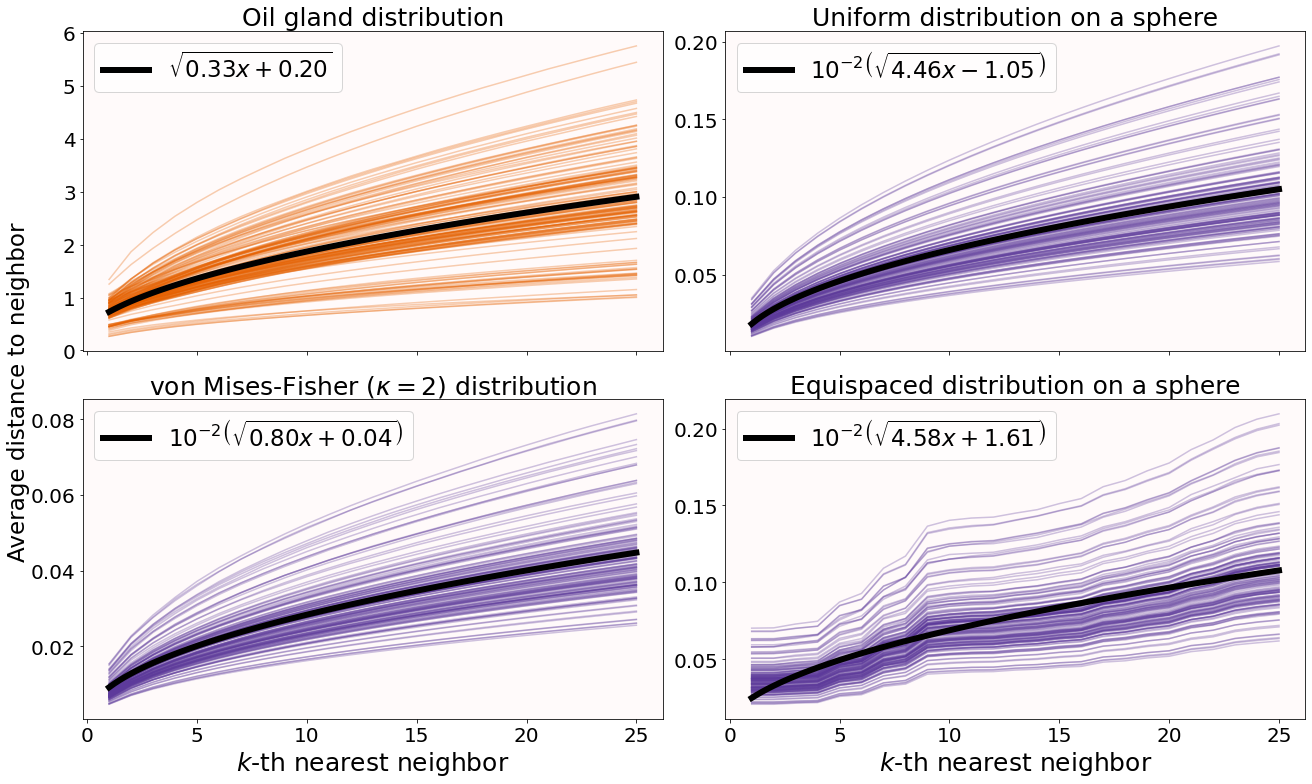

In [20]:
highres = ['#5d3a9b', '#e66100']
fs = 20
tfs = 25
knn_max = 25
knn2 = data
fig, ax = plt.subplots(2,2,figsize=(18,11), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel()
xx = np.arange(knn_max)+1
for i,data in enumerate([unif, vmf, NDist]):
    i += 1
    yy = np.mean(data[:, :knn_max], axis = 0)**2
    new_series = P.Polynomial.fit(xx,yy, deg=1, full=False)
    foo = new_series.convert().coef
    if foo[0] < 0:
        labm = '$10^{{-2}}\\left(\\sqrt{{{:.2f}x {:.2f}}}\\right)$'.format(foo[1]*1e4,foo[0]*1e4)
    else:
        labm = '$10^{{-2}}\\left(\\sqrt{{{:.2f}x + {:.2f}}}\\right)$'.format(foo[1]*1e4,foo[0]*1e4)
    for j in range(len(data)):
        ax[i].plot(xx, data[j, :knn_max],color=highres[0], alpha=0.3)

    ax[i].plot(np.linspace(1,knn_max,100), np.sqrt(new_series(np.linspace(1,knn_max,100))),
               color='k', label=labm, ls='-', lw=6)

ax[1].set_title('Uniform distribution on a sphere', fontsize=tfs);
ax[2].set_title('von Mises-Fisher ($\\kappa = 2$) distribution', fontsize=tfs);
ax[3].set_title('Equispaced distribution on a sphere', fontsize=tfs);

i = 0
yy = np.mean(knn[:, :knn_max], axis = 0)**2
new_series = P.Polynomial.fit(xx,yy, deg=1, full=False)
foo = new_series.convert().coef
labm = '$\\sqrt{{{:.2f}x + {:.2f}}}$'.format(foo[1],foo[0])
for j in range(len(data)):
    ax[i].plot(xx, knn[j, :knn_max],color=highres[1], alpha=0.3)
            
ax[i].plot(np.linspace(1,knn_max,100), np.sqrt(new_series(np.linspace(1,knn_max,100))),
           color='k', label=labm, ls='-', lw=6)

ax[i].set_title('Oil gland distribution', fontsize=tfs);

for i in [2,3]:
    ax[i].set_xlabel('$k$-th nearest neighbor', fontsize=tfs)
    
for i in range(len(ax)):
    ax[i].set_facecolor('snow')
    ax[i].legend(fontsize=23)
    ax[i].tick_params(labelsize=20)
    
fig.text(-0.01, 0.5, 'Average distance to neighbor', va='center', rotation='vertical', fontsize=23)
fig.tight_layout();

pname = src + 'uniform_distribution_{}knn'.format(knn_max)
plt.savefig(pname+'.jpg', dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(pname+'.pdf', format='pdf', bbox_inches='tight')

fig.set_alpha(0)
plt.savefig(pname + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

In [12]:
def regular_directions(N=50, r=1, dims=3):
    if dims==2:
        eq_angles = np.linspace(0, 2*np.pi, num=N, endpoint=False)
        return np.column_stack((np.cos(eq_angles), np.sin(eq_angles)))

    if dims==3:
        dirs = np.zeros((N, 3), dtype=np.float64)
        i = 0
        a = 4*np.pi*r**2/N
        d = np.sqrt(a)
        Mtheta = np.round(np.pi/d)
        dtheta = np.pi/Mtheta
        dphi = a/dtheta
        for m in range(int(Mtheta)):
            theta = np.pi*(m + 0.5)/Mtheta
            Mphi = np.round(2*np.pi*np.sin(theta)/dphi)
            for n in range(int(Mphi)):
                phi = 2*np.pi*n/Mphi
                # sometimes we get an error due to i == N for some choices of N
                if i < N:
                    dirs[i,:] = r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)
                    i += 1

        return dirs
    else:
        print("Function implemented only for 2 and 3 dimensions")

In [13]:
neigh = nn.NearestNeighbors(n_neighbors = 100, radius = 1, algorithm='kd_tree', metric='euclidean')

In [14]:
NDist = np.zeros((len(df), 100))
print(NDist.shape)

(161, 100)


In [15]:
for i in range(len(NDist)):
    N = df['num_glands'][i]
    foo = regular_directions(N)
    neigh.fit(foo)
    ndist, nind = neigh.kneighbors(return_distance=True)
    ndist = ndist.squeeze()
    
    NDist[i] = np.mean(ndist, axis=0)

In [16]:
filename = src + 'regular_distribution_knn.csv'
np.savetxt(filename, NDist, delimiter=',')

In [17]:
src = '../preproc/merged/'
filename = src + 'bingham_distribution_2,1_knn.csv'
filename = src + 'vmf_distribution_2_knn.csv'
vmf = np.loadtxt(filename, delimiter=',')

NameError: name 'bingham' is not defined

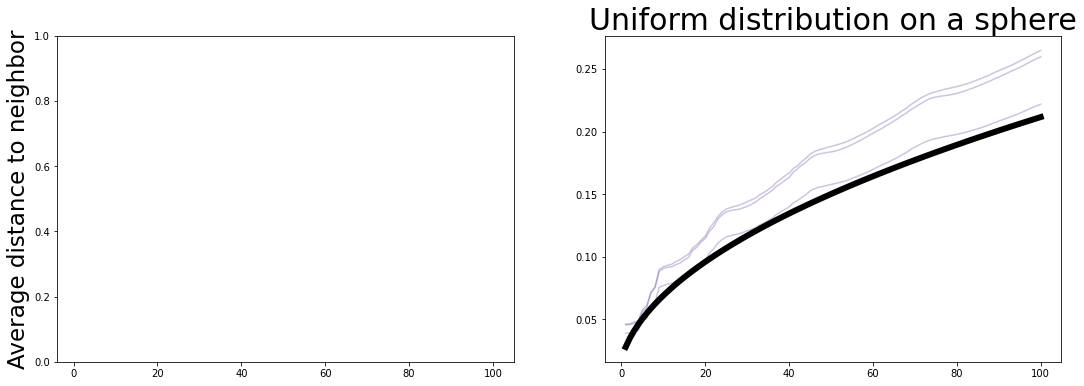

In [18]:
highres = ['#5d3a9b', '#e66100']
fs = 20

knn_max = 100
knn2 = data
fig, ax = plt.subplots(1,2,figsize=(18,6), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel()
xx = np.arange(knn_max)+1
i = 1
yy = np.mean(NDist[:, :knn_max], axis = 0)**2
new_series = P.Polynomial.fit(xx,yy, deg=1, full=False)
foo = new_series.convert().coef
labm = '$10^{{-2}}\\left(\\sqrt{{{:.2f}x + {:.2f}}}\\right)$'.format(foo[1]*1e4,foo[0]*1e4)
for j in range(len(data)):
    ax[i].plot(xx, NDist[j] , color=highres[0], alpha=0.3)
            
ax[i].plot(np.linspace(1,knn_max,100), np.sqrt(new_series(np.linspace(1,knn_max,100))),
           color='k', label=labm, ls='-', lw=6)

ax[0].set_ylabel('Average distance to neighbor', fontsize=23)
ax[i].set_title('Uniform distribution on a sphere', fontsize=30);

i = 0
yy = np.mean(bingham[:, :knn_max], axis = 0)**2
new_series = P.Polynomial.fit(xx,yy, deg=1, full=False)
foo = new_series.convert().coef
labm = '$\\sqrt{{{:.2f}x + {:.2f}}}$'.format(foo[1],foo[0])
for j in range(len(data)):
    ax[i].plot(xx, bingham[j, :knn_max],color=highres[1], alpha=0.3)
            
ax[i].plot(np.linspace(1,knn_max,100), np.sqrt(new_series(np.linspace(1,knn_max,100))),
           color='k', label=labm, ls='-', lw=6)

ax[i].set_title('Oil gland distribution', fontsize=30);

for i in range(len(ax)):
    ax[i].set_facecolor('snow')
    ax[i].tick_params(labelsize=20)
    ax[i].set_xlabel('$k$-th nearest neighbor', fontsize=25)
    ax[i].legend(fontsize=23)


fig.tight_layout();

pname = src + 'uniform_distribution_{}knn'.format(knn_max)
#plt.savefig(pname+'.jpg', dpi=96, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(pname+'.pdf', format='pdf', bbox_inches='tight')